# Linear Classification


In [1]:
import sys, os, json
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import argparse, progressbar
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes

sns.set()


In [2]:
## ml imports
from sklearn import set_config
from sklearn.datasets import load_breast_cancer
from sklearn.experimental import enable_iterative_imputer

set_config(print_changed_only=False)

# import encoders and imputers for feature engineering
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder
)
from sklearn.impute import (
    SimpleImputer,
    IterativeImputer
)

# pipeline and components
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

# import models
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

# import model selection utils
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV,
    GridSearchCV,
    StratifiedKFold,
    RepeatedStratifiedKFold
)

# import metrics for evaluation
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    balanced_accuracy_score,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)

# yellowbrick and others
import shap
import xgbfir
import dtreeviz
import yellowbrick.model_selection as ms
from yellowbrick.classifier import ClassificationReport, DiscriminationThreshold

In [3]:
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Load Data

In [4]:
# bunch is like a dict
data = load_breast_cancer()
type(data)

sklearn.utils._bunch.Bunch

In [5]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [6]:
x, y = data["data"], data["target"]
x.dtype, y.dtype

(dtype('float64'), dtype('int32'))

In [7]:
x.shape, y.shape

((569, 30), (569,))

In [8]:
np.unique(y)

array([0, 1])

In [9]:
data["target_names"]

array(['malignant', 'benign'], dtype='<U9')

In [10]:
data["feature_names"]

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

# Preprocess the dataset

In [11]:
trainx, testx, trainy, testy = train_test_split(x, y,
                                                test_size=0.30,
                                                shuffle=True,
                                                stratify=y)

In [12]:
pd.Series(trainy).value_counts(normalize=True), pd.Series(testy).value_counts(normalize=True)

(1    0.628141
 0    0.371859
 Name: proportion, dtype: float64,
 1    0.625731
 0    0.374269
 Name: proportion, dtype: float64)

In [13]:
N, D = trainx.shape

In [14]:
pd.DataFrame(trainx, columns=list(data["feature_names"]))

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,20.180,19.54,133.80,1250.0,0.11330,0.14890,0.213300,0.125900,0.1724,0.06053,...,22.03,25.07,146.00,1479.0,0.16650,0.29420,0.53080,0.21730,0.3032,0.08075
1,11.700,19.11,74.33,418.7,0.08814,0.05253,0.015830,0.011480,0.1936,0.06128,...,12.61,26.55,80.92,483.1,0.12230,0.10870,0.07915,0.05741,0.3487,0.06958
2,12.050,22.72,78.75,447.8,0.06935,0.10730,0.079430,0.029780,0.1203,0.06659,...,12.57,28.71,87.36,488.4,0.08799,0.32140,0.29120,0.10920,0.2191,0.09349
3,10.820,24.21,68.89,361.6,0.08192,0.06602,0.015480,0.008160,0.1976,0.06328,...,13.03,31.45,83.90,505.6,0.12040,0.16330,0.06194,0.03264,0.3059,0.07626
4,13.940,13.17,90.31,594.2,0.12480,0.09755,0.101000,0.066150,0.1976,0.06457,...,14.62,15.38,94.52,653.3,0.13940,0.13640,0.15590,0.10150,0.2160,0.07253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,14.440,15.18,93.97,640.1,0.09970,0.10210,0.084870,0.055320,0.1724,0.06081,...,15.85,19.85,108.60,766.9,0.13160,0.27350,0.31030,0.15990,0.2691,0.07683
394,13.710,20.83,90.20,577.9,0.11890,0.16450,0.093660,0.059850,0.2196,0.07451,...,17.06,28.14,110.60,897.0,0.16540,0.36820,0.26780,0.15560,0.3196,0.11510
395,9.787,19.94,62.11,294.5,0.10240,0.05301,0.006829,0.007937,0.1350,0.06890,...,10.92,26.29,68.81,366.1,0.13160,0.09473,0.02049,0.02381,0.1934,0.08988
396,13.750,23.77,88.54,590.0,0.08043,0.06807,0.046970,0.023440,0.1773,0.05429,...,15.01,26.34,98.00,706.0,0.09368,0.14420,0.13590,0.06106,0.2663,0.06321


In [15]:
# prepreocessors
sc = StandardScaler()
trainx_transformed = sc.fit_transform(trainx)
testx_transformed = sc.transform(testx)

In [16]:
# convert data types and do reshapes for pytorch
trainx_transformed = torch.from_numpy(trainx_transformed.astype(np.float32))
testx_transformed = torch.from_numpy(testx_transformed.astype(np.float32))

trainy = torch.from_numpy(trainy.astype(np.float32)).reshape(-1, 1)
testy = torch.from_numpy(testy.astype(np.float32)).reshape(-1, 1)

# Build the Model

In [17]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=output_size))

    def forward(self, x):
        logits = self.model(x)
        return logits

# Train the model

In [18]:
model = LogisticRegression(input_size=D,
                           output_size=1)
print(model)

LogisticRegression(
  (model): Sequential(
    (0): Linear(in_features=30, out_features=1, bias=True)
  )
)


In [19]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [20]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

In [21]:
trainx_transformed.shape

torch.Size([398, 30])

In [22]:
# start the training process
# stuff to store
epochs = 1000
train_losses = []
test_losses = []

train_accus = []
test_accus = []

for epoch in range(epochs):
    t0 = datetime.now()

    #move data to device
    inputs, targets = trainx_transformed.to(device), trainy.to(device)

    # zero the grad
    optimizer.zero_grad()

    # forwards pass and get losses
    logits = model(inputs)

    train_loss = criterion(logits, targets)
    train_losses.append(train_loss.item())

    # get accus
    # convert from logits to probabilities
    # 398 X 1
    train_logit_probs = 1 / torch.exp(-logits)
    targets_preds = torch.where(train_logit_probs >= 0.5, 1, 0)
    equals = targets.view(-1, 1) == targets_preds
    train_accu = np.mean(equals.detach().cpu().numpy())
    train_accus.append(train_accu)

    # BACKSTEP
    train_loss.backward()
    optimizer.step()

    # Now validate
    with torch.no_grad():
        model.eval()

        #move data to device
        inputs, targets = testx_transformed.to(device), testy.to(device)

        # forwards pass and get losses
        logits = model(inputs)

        test_loss = criterion(logits, targets)
        test_losses.append(test_loss.item())

        # get accus
        # convert from logits to probabilities
        test_logit_probs = 1 / torch.exp(-logits)
        targets_preds = torch.where(test_logit_probs >= 0.5, 1, 0)
        equals = targets.view(-1, 1) == targets_preds
        test_accu = np.mean(equals.detach().cpu().numpy())
        test_accus.append(test_accu)

    model.train()

    # now getting out to the next epoch
    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch + 1}\n"
              f"TrainLoss: {train_losses[epoch]:0.2f},"
              f"TestLoss: {test_losses[epoch]:0.2f},")
        print(f"TrainAcc: {train_accus[epoch]:0.2f},"
              f"TestAccus: {test_accus[epoch]:0.2f}")
        print(f"Duration: {datetime.now() - t0}")
        print("=" * 50)

Epoch: 10
TrainLoss: 0.96,TestLoss: 0.97,
TrainAcc: 0.51,TestAccus: 0.51
Duration: 0:00:00.001011
Epoch: 20
TrainLoss: 0.88,TestLoss: 0.89,
TrainAcc: 0.55,TestAccus: 0.57
Duration: 0:00:00.013146
Epoch: 30
TrainLoss: 0.81,TestLoss: 0.82,
TrainAcc: 0.57,TestAccus: 0.59
Duration: 0:00:00
Epoch: 40
TrainLoss: 0.74,TestLoss: 0.75,
TrainAcc: 0.59,TestAccus: 0.62
Duration: 0:00:00.002041
Epoch: 50
TrainLoss: 0.68,TestLoss: 0.70,
TrainAcc: 0.63,TestAccus: 0.67
Duration: 0:00:00.002047
Epoch: 60
TrainLoss: 0.63,TestLoss: 0.65,
TrainAcc: 0.66,TestAccus: 0.70
Duration: 0:00:00.001038
Epoch: 70
TrainLoss: 0.59,TestLoss: 0.60,
TrainAcc: 0.72,TestAccus: 0.73
Duration: 0:00:00.001506
Epoch: 80
TrainLoss: 0.55,TestLoss: 0.57,
TrainAcc: 0.76,TestAccus: 0.74
Duration: 0:00:00.000999
Epoch: 90
TrainLoss: 0.52,TestLoss: 0.53,
TrainAcc: 0.79,TestAccus: 0.77
Duration: 0:00:00.001313
Epoch: 100
TrainLoss: 0.49,TestLoss: 0.50,
TrainAcc: 0.80,TestAccus: 0.78
Duration: 0:00:00.000998
Epoch: 110
TrainLoss: 0.47

''

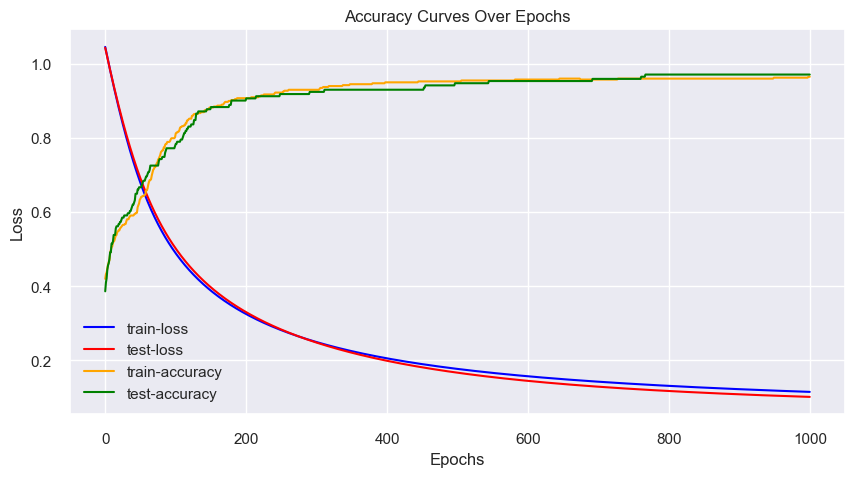

In [23]:
# init fig and axes objects
sns.set(font_scale=1)
nrows = 1
ncols = 1
fig_height = nrows * 5
fig_width = ncols * 10
f: Figure
ax: Axes
f, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_height))
# %% ##################################################################
ax_ = sns.lineplot(
    x=np.arange(epochs),
    y=train_losses,
    ax=ax,
    color="blue",
    label="train-loss")
ax_ = sns.lineplot(
    x=np.arange(epochs),
    y=test_losses,
    ax=ax,
    color="red",
    label="test-loss")
ax_.set(title="Loss Curves Over Epochs", ylabel="Loss", xlabel="Epochs")
# %% ##################################################################
ax_ = sns.lineplot(
    x=np.arange(epochs),
    y=train_accus,
    ax=ax,
    color="orange",
    label="train-accuracy")
ax_ = sns.lineplot(
    x=np.arange(epochs),
    y=test_accus,
    ax=ax,
    color="green",
    label="test-accuracy")
ax_.set(title="Accuracy Curves Over Epochs", ylabel="Loss", xlabel="Epochs")
;